Link Colab: https://colab.research.google.com/drive/1r3m9-tvkJut5anzyd312SSsWoyaWYrvE?usp=sharing

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [ ]:
#Collegare Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importare roboflow e scaricare il dataset
from roboflow import Roboflow
rf = Roboflow(api_key="IwbjvxFzcbBgxgAJv6M2")
project = rf.workspace("aslvsbsl").project("aslvbsl")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ASLvBSL-2 in folder:: 100%|██████████| 5909/5909 [00:02<00:00, 2297.79it/s]


In [ ]:
import os

# Impostare il percorso dei dati scaricati
dataset_path = dataset.location  # Questo imposta automaticamente il percorso del dataset scaricato

# Impostare i percorsi in base alla struttura stampata
train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')
test_dir = os.path.join(dataset_path, 'test')

# Verifica delle directory
assert os.path.exists(train_dir), f"Directory {train_dir} non trovata."
assert os.path.exists(valid_dir), f"Directory {valid_dir} non trovata."
assert os.path.exists(test_dir), f"Directory {test_dir} non trovata."

print("Tutte le directory esistono.")

Tutte le directory esistono.


Found 3840 images belonging to 48 classes.
Found 672 images belonging to 48 classes.
Found 1248 images belonging to 48 classes.
Epoch 1/60
120/120 [==============================] - 45s 359ms/step - loss: 4.9202 - accuracy: 0.5750 - val_loss: 2.9530 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 2/60
120/120 [==============================] - 43s 356ms/step - loss: 2.0533 - accuracy: 0.9125 - val_loss: 2.0113 - val_accuracy: 0.8363 - lr: 1.0000e-04
Epoch 3/60
120/120 [==============================] - 43s 359ms/step - loss: 1.4500 - accuracy: 0.9581 - val_loss: 1.6275 - val_accuracy: 0.8720 - lr: 1.0000e-04
Epoch 4/60
120/120 [==============================] - 45s 377ms/step - loss: 1.1495 - accuracy: 0.9716 - val_loss: 1.3808 - val_accuracy: 0.8810 - lr: 1.0000e-04
Epoch 5/60
120/120 [==============================] - 43s 358ms/step - loss: 0.9521 - accuracy: 0.9802 - val_loss: 1.2144 - val_accuracy: 0.8765 - lr: 1.0000e-04
Epoch 6/60
120/120 [==============================] - 44s 366m

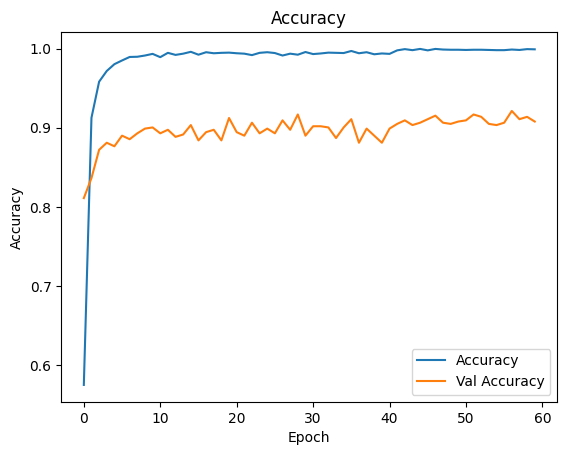

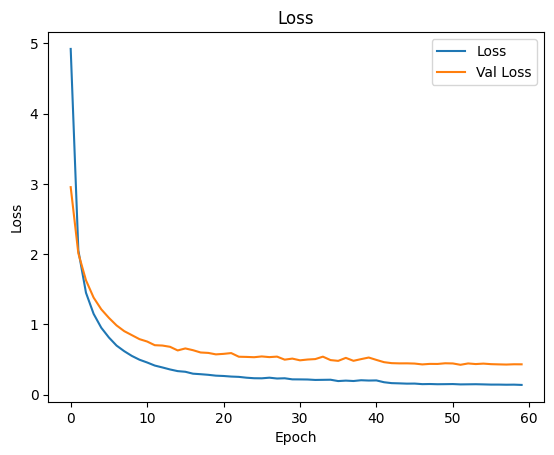

39/39 [==============================] - 13s 326ms/step - loss: 0.4578 - accuracy: 0.8942
Test accuracy: 0.8942307829856873


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt

# Caricamento del dataset
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Creazione del modello VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(48, activation='softmax'))

# Compilazione del modello
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Aggiungere EarlyStopping e ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Allena il modello
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, reduce_lr]
)

# Visualizzazione dell'accuratezza di training e validation
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizzazione della perdita di training e validation
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Valutazione del modello sul set di test
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Salvataggio del modello
model.save('/content/drive/MyDrive/vgg16_model_v1.h5')

Found 3840 images belonging to 48 classes.
Found 672 images belonging to 48 classes.
Found 1248 images belonging to 48 classes.
58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/80
120/120 [==============================] - 99s 725ms/step - loss: 9.8262 - accuracy: 0.0591 - val_loss: 8.0145 - val_accuracy: 0.3914 - lr: 5.0000e-05
Epoch 2/80
120/120 [==============================] - 89s 741ms/step - loss: 7.3731 - accuracy: 0.2245 - val_loss: 5.5078 - val_accuracy: 0.7307 - lr: 5.0000e-05
Epoch 3/80
120/120 [==============================] - 85s 710ms/step - loss: 5.8346 - accuracy: 0.4414 - val_loss: 4.5206 - val_accuracy: 0.8244 - lr: 5.0000e-05
Epoch 4/80
120/120 [==============================] - 87s 726ms/step - loss: 4.8993 - accuracy: 0.6029 - val_loss: 3.9176 - val_accuracy: 0.8958 - lr: 5.0000e-05
Epoch 5/80
120/120 [==============================] - 88s 736ms/step - loss: 4.3395 - accuracy: 0.7146 - val_loss: 3.6073 - val_accuracy: 0.9048 - lr: 5.0000e-

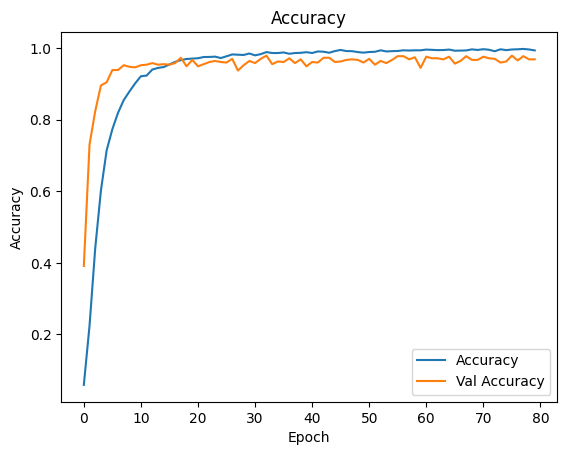

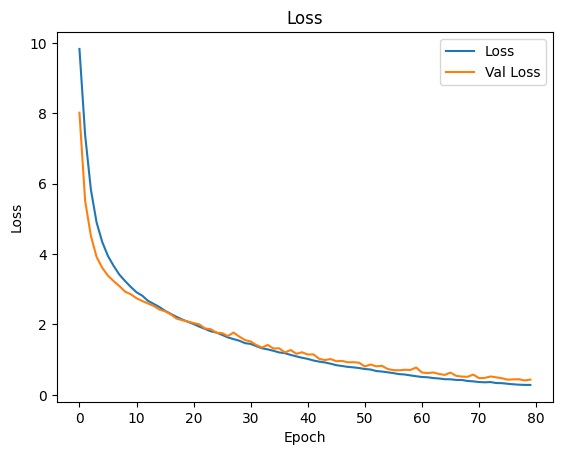

39/39 [==============================] - 12s 302ms/step - loss: 0.4308 - accuracy: 0.9696
Test accuracy: 0.9695512652397156


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt

# Caricamento del dataset con data augmentation ridotta
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Creazione del modello VGG16 con fine-tuning
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers[:-4]:  # Congela tutti gli strati tranne gli ultimi 4
    layer.trainable = False

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))  # Aggiunto un ulteriore livello Dense con Dropout
model.add(Dropout(0.5))
model.add(Dense(48, activation='softmax'))

# Compilazione del modello con learning rate modificato
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy'])

# Aggiungere EarlyStopping e ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Allena il modello
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=80,  # Aumentato il numero di epoche
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping, reduce_lr]
)

# Visualizzazione dell'accuratezza di training e validation
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizzazione della perdita di training e validation
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Valutazione del modello sul set di test
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Salvataggio del modello
model.save('/content/drive/MyDrive/vgg16_model_v2.h5')